In [11]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(1, 'dnn/')

# del bnn
import bcell_nn as bnn
import bcell_plot
import bcell_preprocess as bpreprocess
# import bcell_driver

# System arguments
import argparse
# data management
import numpy as np
import pandas as pd
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# flow cytometry libraries
import cytoflow as flow
# user defined functions

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9237567583143748483
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17236365173009617228
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13938741275630553361
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11141855360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3159990129296233153
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [14]:
# specify data files
marrow_basal_file = '../data/B_cell_data/Marrow1_01_Basal1.fcs'
marrow_bcr_file   = '../data/B_cell_data/Marrow1_06_BCR.fcs'

# using the cytoflow package
basal_tube = flow.Tube(file = marrow_basal_file,
                  conditions = {'bcr' : 0.0})
bcr_tube   = flow.Tube(file=marrow_bcr_file,
                  conditions = {'bcr' : 1.0})

import_op = flow.ImportOp(conditions = {'bcr' : 'float'},
                          tubes = [basal_tube, bcr_tube])


ex = import_op.apply()

In [15]:
USE = 0.02
VAL = 0.2
TEST = 0.2

In [16]:
cells_df   = bpreprocess.tube_to_df(ex)
cyto_dataset = bpreprocess.df_to_train_tensor(cells_df, use=USE)

In [17]:
train_dataset, val_dataset, test_dataset = bpreprocess.split_dataset(cyto_dataset, VAL, TEST)

## Test best shape

In [1]:
shapes = [
    [20, 7],
    [20, 16, 16, 8],
    [20, 16, 16, 16],
    [20, 16, 32, 16, 8],
    [16, 32, 128, 32, 16]
]

In [15]:
def define_model(shape=None, dropout=0.1):

    ###
    # inputs:
    #   shape: the number of nodes per each layer of neural network. First element is the input size
    #   dropout: dropout layer will be added to the penultimate layer, dropout size
    ###

    model = None
    if not shape:
        # Define Sequential model with 3 layers
        model = keras.Sequential(
            [
                layers.Dense(20, activation="relu", name="layer1"),
                layers.Dense(7, activation="relu", name="layer2"),
#                 layers.Dropout(dropout),
                layers.Dense(1, activation='sigmoid', name="layer3"),
            ]
        )
    
    else:
        model = keras.Sequential()
        for i, x in enumerate(shape):
            model.add(layers.Dense(x, activation='relu', name='layer%d' % (i+1)))
        model.add(layers.Dropout(dropout, name='dropout'))
        model.add(layers.Dense(1, activation='sigmoid', name='layer%d' % (i+2)))


    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    return model

In [89]:
accs = []
losses = []
for s in shapes:
    temp_score = 0
    temp_acc = 0
    N = 3
    for _ in range(N):
        model = define_model(shape=s, dropout=0)
        _, history = bnn.fit_model(model, train_dataset, val_dataset, train_dataset, batch_size=128, epochs=10)
        score, acc = model.evaluate(test_dataset)
        temp_score += score
        temp_acc += acc
    print('\n')
    print('Test score:', temp_score/N)
    print('Test accuracy:', temp_acc/N)
    print('\n')
    
    accs.append(temp_acc/N)
    losses.append(temp_score/N)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10270/10270 [==============================] - 16s 2ms/step - loss: 1.9319 - accuracy: 0.5837 - val_loss: 0.8116 - val_accuracy: 0.5692
Epoch 2/10
10270/10270 [==============================] - 16s 2ms/step - loss: 1.1515 - accuracy: 0.5775 - val_loss: 0.8809 - val_accuracy: 0.5652
Epoch 3/10
10270/10270 [==============================] - 16s 2ms/step - loss: 1.0794 - accuracy: 0.5799 - val_loss: 0.8327 - val_accuracy: 0.5779
Epoch 4/10
10270/10270 [==============================] - 16s 2ms/s

10270/10270 [==============================] - 16s 2ms/step - loss: 0.5242 - accuracy: 0.7424 - val_loss: 0.4961 - val_accuracy: 0.7539
Epoch 6/10
10270/10270 [==============================] - 17s 2ms/step - loss: 0.5091 - accuracy: 0.7438 - val_loss: 0.5262 - val_accuracy: 0.7616
Epoch 7/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.4967 - accuracy: 0.7578 - val_loss: 0.4903 - val_accuracy: 0.7594
Epoch 8/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.5070 - accuracy: 0.7503 - val_loss: 0.4606 - val_accuracy: 0.7813
Epoch 9/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.4819 - accuracy: 0.7614 - val_loss: 0.4945 - val_accuracy: 0.7623
Epoch 10/10
3465/3465 [==============================] - 3s 947us/step - loss: 0.4856 - accuracy: 0.7639892 - accurac
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are por

10270/10270 [==============================] - 16s 2ms/step - loss: 1.3186 - accuracy: 0.6107 - val_loss: 0.6541 - val_accuracy: 0.6970
Epoch 2/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.6248 - accuracy: 0.6854 - val_loss: 0.5489 - val_accuracy: 0.7280
Epoch 3/10
10270/10270 [==============================] - 17s 2ms/step - loss: 0.5464 - accuracy: 0.7243 - val_loss: 0.5080 - val_accuracy: 0.7474
Epoch 4/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.5725 - accuracy: 0.7279 - val_loss: 0.5350 - val_accuracy: 0.7492
Epoch 5/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.5358 - accuracy: 0.7407 - val_loss: 0.5195 - val_accuracy: 0.7411
Epoch 6/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.5242 - accuracy: 0.7393 - val_loss: 0.5163 - val_accuracy: 0.7514
Epoch 7/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.5255 - accuracy: 0.7454 - val_loss: 0.5053 - val

Epoch 10/10
3465/3465 [==============================] - 3s 962us/step - loss: 0.4633 - accuracy: 0.7677
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10270/10270 [==============================] - 16s 2ms/step - loss: 0.7280 - accuracy: 0.5685 - val_loss: 0.6824 - val_accuracy: 0.5728
Epoch 2/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.6886 - accuracy: 0.5709 - val_loss: 0.6819 - val_accuracy: 0.5750
Epoch 3/10
10270/10270 [==============================] - 16s 2ms/step - loss: 0.6793 - accuracy: 0.5837 - va

[0.6319384376207987,
 0.694372296333313,
 0.7641173601150513,
 0.637902836004893,
 0.6405964493751526]

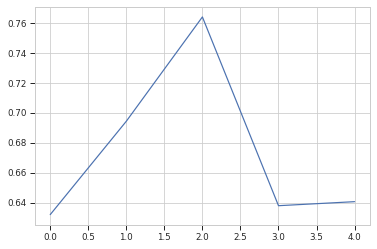

In [91]:
plt.plot(accs)
# [0.8035136461257935,
#  0.5715441703796387,
#  0.8144937753677368,
#  0.8509015440940857,
#  0.7903375029563904]

# [0.6319384376207987,
#  0.694372296333313,
#  0.7641173601150513,
#  0.637902836004893,
#  0.6405964493751526]
accs

[0.6201181014378866,
 0.556937058766683,
 0.4964560866355896,
 0.6097364525000254,
 0.6192682484785715]

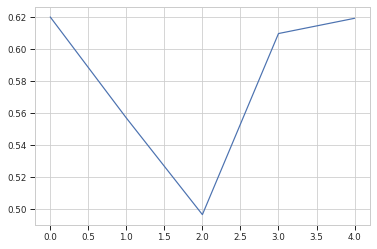

In [92]:
plt.plot(losses)
losses
# [0.4393937885761261,
#  0.6832538843154907,
#  0.41677165031433105,
#  0.352311909198761,
#  0.46169131994247437]

# [0.6201181014378866,
#  0.556937058766683,
#  0.4964560866355896,
#  0.6097364525000254,
#  0.6192682484785715]

## Test different dropouts

In [20]:
dropouts = np.linspace(0.0, 0.5, 6)

In [21]:
accs = []
losses = []
for d in dropouts:
    temp_score = 0
    temp_acc = 0
    N = 3
    for _ in range(N):
        model = define_model(shape=[20, 16, 32, 16, 8], dropout=d)
        _, history = bnn.fit_model(model, train_dataset, val_dataset, train_dataset, batch_size=256, epochs=10)
        score, acc = model.evaluate(test_dataset)
        
        temp_score += score
        temp_acc += acc
    print('\n')
    print('Test score:', temp_score/N)
    print('Test accuracy:', temp_acc/N)
    print('\n')
    
    accs.append(temp_acc/N)
    losses.append(temp_score/N)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10270/10270 [==============================] - 35s 3ms/step - loss: 0.9919 - accuracy: 0.6345 - val_loss: 0.6048 - val_accuracy: 0.7083
Epoch 2/10
10270/10270 [==============================] - 34s 3ms/step - loss: 0.5774 - accuracy: 0.7115 - val_loss: 0.5270 - val_accuracy: 0.7411
Epoch 3/10
10270/10270 [==============================] - 34s 3ms/step - loss: 0.5508 - accuracy: 0.7258 - val_loss: 0.5410 - val_accuracy: 0.7196
Epoch 4/10
10270/10270 [==============================] - 34s 3ms/s

10270/10270 [==============================] - 33s 3ms/step - loss: 0.7669 - accuracy: 0.5672 - val_loss: 0.6820 - val_accuracy: 0.5725
Epoch 2/10
10270/10270 [==============================] - 34s 3ms/step - loss: 0.6926 - accuracy: 0.5653 - val_loss: 0.6840 - val_accuracy: 0.5659
Epoch 3/10
10270/10270 [==============================] - 34s 3ms/step - loss: 0.6962 - accuracy: 0.5709 - val_loss: 0.6945 - val_accuracy: 0.5798
Epoch 4/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6953 - accuracy: 0.5745 - val_loss: 0.6817 - val_accuracy: 0.5758
Epoch 5/10
10270/10270 [==============================] - 34s 3ms/step - loss: 0.6826 - accuracy: 0.5716 - val_loss: 0.6822 - val_accuracy: 0.5732
Epoch 6/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6830 - accuracy: 0.5728 - val_loss: 0.7037 - val_accuracy: 0.5838
Epoch 7/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6937 - accuracy: 0.5715 - val_loss: 0.6797 - val

Epoch 10/10
3465/3465 [==============================] - 7s 2ms/step - loss: 0.6829 - accuracy: 0.5714
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10270/10270 [==============================] - 34s 3ms/step - loss: 0.7981 - accuracy: 0.5654 - val_loss: 0.6848 - val_accuracy: 0.5644
Epoch 2/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6946 - accuracy: 0.5669 - val_loss: 0.6860 - val_accuracy: 0.5608
Epoch 3/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6839 - accuracy: 0.5703 - val_

In [31]:
accs = [[0.7841, 0.7911, 0.5697],
        [0.7573, 0.7680, 0.5619],
        [0.5758, 0.5723, 0.5706],
        [0.5671, 0.5714, 0.5619],
        [0.5804, 0.5859, 0.5732],
        [0.5694, 0.5729, 0.5734]
       ]
losses = [[0.4556, 0.4436, 0.6835],
            [0.4797, 0.4795, 0.6856],
            [0.6816, 0.6818, 0.6831],
            [0.6841, 0.6829, 0.6855],
            [0.6802, 0.6785, 0.6826],
            [0.6835, 0.6826, 0.6821]
         ]

accs = np.array(accs).mean(axis=1)
losses = np.array(losses).mean(axis=1)

array([0.71496667, 0.69573333, 0.5729    , 0.5668    , 0.57983333,
       0.5719    ])

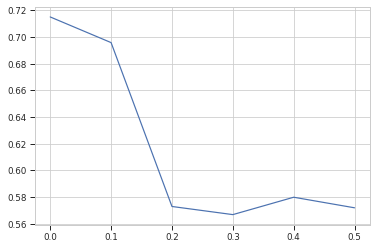

In [32]:
plt.plot(dropouts, accs)
accs

array([0.52756667, 0.54826667, 0.68216667, 0.68416667, 0.68043333,
       0.68273333])

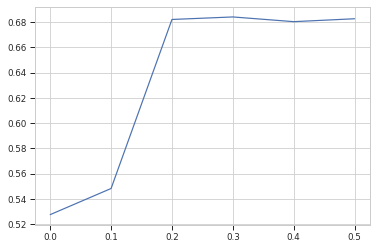

In [33]:
plt.plot(dropouts, losses)
losses

## PCA

In [18]:
ndims = np.arange(5, 20, 5)

In [20]:
accs = []
losses = []
for d in ndims:
    
    print('\n***************** {} ********************\n'.format(d))
    
    cells_df   = bpreprocess.tube_to_df(ex)
    cyto_dataset = bpreprocess.df_to_train_tensor(cells_df, use=USE, pca=d)

    train_dataset, val_dataset, test_dataset = bpreprocess.split_dataset(cyto_dataset, VAL, TEST)
    
    temp_score = 0
    temp_acc = 0
    N = 3
    for _ in range(N):
        model = bnn.define_model(shape=[20, 16, 32, 16, 8], dropout=0.1)
        _, history = bnn.fit_model(model, train_dataset, val_dataset, train_dataset, epochs=10)
        score, acc = model.evaluate(test_dataset)
        
        temp_score += score
        temp_acc += acc
    print('\n')
    print('Test score:', temp_score/N)
    print('Test accuracy:', temp_acc/N)
    print('\n')
    
    accs.append(temp_acc/N)
    losses.append(temp_score/N)


***************** 5 ********************

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10270/10270 [==============================] - 37s 4ms/step - loss: 0.8719 - accuracy: 0.5602 - val_loss: 0.7100 - val_accuracy: 0.5692
Epoch 2/10
10270/10270 [==============================] - 35s 3ms/step - loss: 0.6818 - accuracy: 0.5722 - val_loss: 0.6842 - val_accuracy: 0.5666
Epoch 3/10
10270/10270 [==============================] - 35s 3ms/step - loss: 0.6840 - accuracy: 0.5695 - val_loss: 0.6815 - val_accuracy: 0.5779
Epoch 4/10
10270/10270 [

3465/3465 [==============================] - 7s 2ms/step - loss: 0.6011 - accuracy: 0.6626
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10270/10270 [==============================] - 34s 3ms/step - loss: 0.7530 - accuracy: 0.5685 - val_loss: 0.6809 - val_accuracy: 0.5772
Epoch 2/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6860 - accuracy: 0.5622 - val_loss: 0.6841 - val_accuracy: 0.5674
Epoch 3/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6840 - accuracy: 0.5670 - val_loss: 0.6829

10270/10270 [==============================] - 33s 3ms/step - loss: 0.6516 - accuracy: 0.6430 - val_loss: 0.6719 - val_accuracy: 0.5878
Epoch 7/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6353 - accuracy: 0.6526 - val_loss: 0.6177 - val_accuracy: 0.6710
Epoch 8/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6236 - accuracy: 0.6666 - val_loss: 0.5896 - val_accuracy: 0.6857
Epoch 9/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.6059 - accuracy: 0.6760 - val_loss: 0.5832 - val_accuracy: 0.7003
Epoch 10/10
3465/3465 [==============================] - 7s 2ms/step - loss: 0.6152 - accuracy: 0.6355
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just

[0.5696007609367371, 0.6315536300341288, 0.5906685789426168]

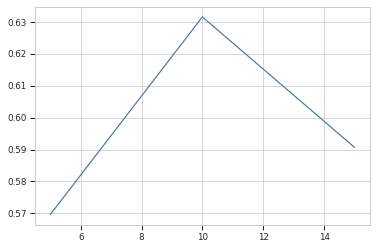

In [22]:
plt.plot(ndims, accs)
accs

[0.6835238337516785, 0.6302804946899414, 0.6609857479731241]

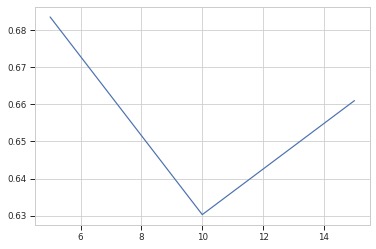

In [23]:
plt.plot(ndims, losses)
losses

In [25]:
accs = []
losses = []
for d in [20, 25]:
    
    print('\n***************** {} ********************\n'.format(d))
    
    cells_df   = bpreprocess.tube_to_df(ex)
    cyto_dataset = bpreprocess.df_to_train_tensor(cells_df, use=USE, pca=d)

    train_dataset, val_dataset, test_dataset = bpreprocess.split_dataset(cyto_dataset, VAL, TEST)
    
    temp_score = 0
    temp_acc = 0
    N = 3
    for _ in range(N):
        model = bnn.define_model(shape=[20, 16, 32, 16, 8], dropout=0.1)
        _, history = bnn.fit_model(model, train_dataset, val_dataset, train_dataset, epochs=10)
        score, acc = model.evaluate(test_dataset)
        
        temp_score += score
        temp_acc += acc
    print('\n')
    print('Test score:', temp_score/N)
    print('Test accuracy:', temp_acc/N)
    print('\n')
    
    accs.append(temp_acc/N)
    losses.append(temp_score/N)


***************** 20 ********************

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10270/10270 [==============================] - 35s 3ms/step - loss: 0.9660 - accuracy: 0.6076 - val_loss: 0.6073 - val_accuracy: 0.6751
Epoch 2/10
10270/10270 [==============================] - 35s 3ms/step - loss: 0.6214 - accuracy: 0.6772 - val_loss: 0.5620 - val_accuracy: 0.7229
Epoch 3/10
10270/10270 [==============================] - 34s 3ms/step - loss: 0.5996 - accuracy: 0.6843 - val_loss: 0.5929 - val_accuracy: 0.7068
Epoch 4/10
10270/10270 

10270/10270 [==============================] - 33s 3ms/step - loss: 0.5613 - accuracy: 0.7014 - val_loss: 0.5260 - val_accuracy: 0.7357
Epoch 5/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.5525 - accuracy: 0.7193 - val_loss: 0.5213 - val_accuracy: 0.7444
Epoch 6/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.5507 - accuracy: 0.7206 - val_loss: 0.4923 - val_accuracy: 0.7466
Epoch 7/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.5424 - accuracy: 0.7150 - val_loss: 0.5204 - val_accuracy: 0.7379
Epoch 8/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.5145 - accuracy: 0.7294 - val_loss: 0.5064 - val_accuracy: 0.7317
Epoch 9/10
10270/10270 [==============================] - 33s 3ms/step - loss: 0.4987 - accuracy: 0.7500 - val_loss: 0.5310 - val_accuracy: 0.7536
Epoch 10/10
3465/3465 [==============================] - 7s 2ms/step - loss: 0.4560 - accuracy: 0.7775
Epoch 1/10

If you intende

In [26]:
accs


[0.7184223135312399, 0.7027417023976644]

In [27]:
losses

[0.5566580494244894, 0.5430114964644114]

In [30]:
# acc
[0.5696007609367371, 0.6315536300341288, 0.5906685789426168, 0.7184223135312399, 0.7027417023976644]

[0.5696007609367371,
 0.6315536300341288,
 0.5906685789426168,
 0.7184223135312399,
 0.7027417023976644]

In [31]:
# loss
[0.6835238337516785, 0.6302804946899414, 0.6609857479731241, 0.5566580494244894, 0.5430114964644114]

[0.6835238337516785,
 0.6302804946899414,
 0.6609857479731241,
 0.5566580494244894,
 0.5430114964644114]